In [2]:
import numpy as np
import cupy as cp
from cupyx import jit
import pylab as plt
import time

In [41]:
@jit.rawkernel()
def mykernel(pos, vel, i, n):
    row = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x
    dt = 10; 
    mu = 398600
    
    if row < n:    
        xin = pos[row, i, 0]
        yin = pos[row, i, 1]
        zin = pos[row, i, 2]
        vxin = vel[row, i, 0]
        vyin = vel[row, i, 1]
        vzin = vel[row, i, 2]

        pos[row, i + 1, 0] = xin + dt * vxin
        pos[row, i + 1, 1] = yin + dt * vyin
        pos[row, i + 1, 2] = zin + dt * vzin

        r = cp.sqrt(xin*xin + yin*yin + zin*zin)
        ax = - mu * xin / r**3
        ay = - mu * yin / r**3
        az = - mu * zin / r**3

        vel[row, i + 1, 0] = vxin + dt * ax
        vel[row, i + 1, 1] = vyin + dt * ay
        vel[row, i + 1, 2] = vzin + dt * az

/home/ubuntu/.local/lib/python3.6/site-packages/cupyx/jit/_interface.py:156: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [47]:
# Initialize
npartices = 100_000
nsteps = 50

pos = np.zeros((npartices, nsteps, 3))
pos[:, 0, 0] = 0
pos[:, 0, 1] = 0
pos[:, 0, 2] = 6378.14 # 1 Re in km
pos = cp.array(pos)

vel = np.zeros((npartices, nsteps, 3)) 
vel[:, 0, 0] = -7.6  # km/s
vel[:, 0, 1] = 0
vel[:, 0, 2] = 0
vel = cp.array(vel)

# Define the block and grid dimensions
threads_per_block = 1024
blocks_per_grid = ( (pos.shape[0] + threads_per_block - 1) // threads_per_block, )

print(threads_per_block)
print(blocks_per_grid)

1024
(98,)


In [31]:
assert not np.isnan(pos.get()).any() 
assert not np.isnan(vel.get()).any()

In [46]:
start_time = time.time()

for i in range(nsteps - 1):
    mykernel(blocks_per_grid, (threads_per_block,), (pos, vel, i, pos.shape[0]))

pos_history = pos.get()
vel_history = vel.get()

print(f'Took {time.time() - start_time} sec')

Took 0.14076495170593262 sec


In [38]:
pos_history.shape

(100000, 50, 3)

Text(0, 0.5, 'Z ($R_E$)')

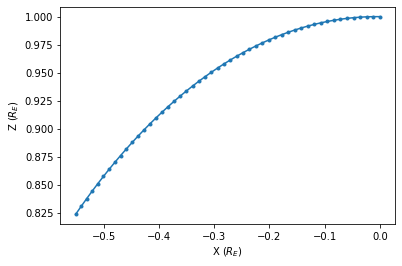

In [39]:
plt.plot(pos_history[0, :, 0] / 6378.14,
         pos_history[0, :, 2] / 6378.14,
         '.-')
plt.xlabel('X ($R_E$)')
plt.ylabel('Z ($R_E$)')

Text(0, 0.5, 'Velocity (km/s)')

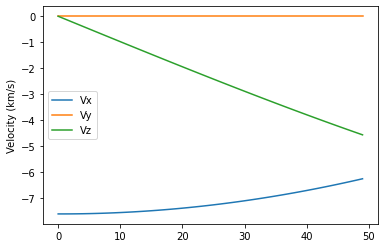

In [44]:
plt.plot(vel_history[0, :, 0], label='Vx')
plt.plot(vel_history[0, :, 1], label='Vy')
plt.plot(vel_history[0, :, 2], label='Vz')
plt.legend()
plt.ylabel('Velocity (km/s)')